In [1]:
%reset -sf

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.empty_cache()
import matplotlib.pyplot as plt

from timeit import default_timer
from utilities_new import UnitGaussianNormalizer, count_params, LpLoss
from pytorch_wavelets import DTCWTForward, DTCWTInverse

torch.manual_seed(0)
np.random.seed(0)

device = 'cuda:1'

In [2]:
""" Def: 2d Wavelet layer """

class WaveConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, level, dummy):
        super(WaveConv2d, self).__init__()

        """
        2D Wavelet layer. It does DWT, linear transform, and Inverse dWT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.level = level
        self.dwt_ = DTCWTForward(J=self.level, biort='near_sym_b', qshift='qshift_b').to(dummy.device)
        self.mode_dwt, self.coef_dwt = self.dwt_(dummy) 
        self.modes1 = self.mode_dwt.shape[-2]
        self.modes2 = self.mode_dwt.shape[-1]
        self.modes3 = self.coef_dwt[-1].shape[-3]
        self.modes4 = self.coef_dwt[-1].shape[-2]

        self.scale = (1 / (in_channels * out_channels))
        self.weights0 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2))
        self.weights1a = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights1b = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights2a = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights2b = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights3a = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights3b = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights4a = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights4b = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights5a = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights5b = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights6a = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights6b = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        
    # Convolution
    def mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        
        # Compute single tree Discrete Wavelet coefficients using some wavelet
        dwt = DTCWTForward(J=self.level, biort='near_sym_b', qshift='qshift_b').to(x.device)
        # Sharp therefore, symmetric --> zero, db2
        x_ft, x_coeff = dwt(x)

        # Multiply relevant Wavelet modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x_ft.shape[-2], x_ft.shape[-1], device=x.device)
        
        out_ft[:, :, :, :] = self.mul2d(x_ft[:, :, :, :], self.weights0)
        # Multiply the finer wavelet coefficients
        x_coeff[-1][:,:,0,:,:,0] = self.mul2d(x_coeff[-1][:,:,0,:,:,0].clone(), self.weights1a)
        x_coeff[-1][:,:,0,:,:,1] = self.mul2d(x_coeff[-1][:,:,0,:,:,1].clone(), self.weights1b)
        x_coeff[-1][:,:,1,:,:,0] = self.mul2d(x_coeff[-1][:,:,1,:,:,0].clone(), self.weights2a)
        x_coeff[-1][:,:,1,:,:,1] = self.mul2d(x_coeff[-1][:,:,1,:,:,1].clone(), self.weights2b)
        x_coeff[-1][:,:,2,:,:,0] = self.mul2d(x_coeff[-1][:,:,2,:,:,0].clone(), self.weights3a)
        x_coeff[-1][:,:,2,:,:,1] = self.mul2d(x_coeff[-1][:,:,2,:,:,1].clone(), self.weights3b)
        x_coeff[-1][:,:,3,:,:,0] = self.mul2d(x_coeff[-1][:,:,3,:,:,0].clone(), self.weights4a)
        x_coeff[-1][:,:,3,:,:,1] = self.mul2d(x_coeff[-1][:,:,3,:,:,1].clone(), self.weights4b)
        x_coeff[-1][:,:,4,:,:,0] = self.mul2d(x_coeff[-1][:,:,4,:,:,0].clone(), self.weights5a)
        x_coeff[-1][:,:,4,:,:,1] = self.mul2d(x_coeff[-1][:,:,4,:,:,1].clone(), self.weights5b)
        x_coeff[-1][:,:,5,:,:,0] = self.mul2d(x_coeff[-1][:,:,5,:,:,0].clone(), self.weights6a)
        x_coeff[-1][:,:,5,:,:,1] = self.mul2d(x_coeff[-1][:,:,5,:,:,1].clone(), self.weights6b)
        
        # Return to physical space        
        idwt = DTCWTInverse(biort='near_sym_b', qshift='qshift_b').to(x.device)
        x = idwt((out_ft, x_coeff))
        
        return x

In [3]:
""" The forward operation """

class WNO2d(nn.Module):
    def __init__(self, width, level, dummy_data):
        super(WNO2d, self).__init__()

        """
        The WNO network. It contains 4 layers of the Wavelet integral layer.
        1. Lift the input using v(x) = self.fc0 .
        2. 4 layers of the integral operators v(+1) = g(K(.) + W)(v).
            W is defined by self.w_; K is defined by self.conv_.
        3. Project the output of last layer using self.fc1 and self.fc2.
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.level = level
        self.width = width
        self.dummy_data = dummy_data
        self.padding = 2 # pad the domain if input is non-periodic
        
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y) and x, y)

        self.conv0 = WaveConv2d(self.width, self.width, self.level, self.dummy_data)
        self.conv1 = WaveConv2d(self.width, self.width, self.level, self.dummy_data)
        self.conv2 = WaveConv2d(self.width, self.width, self.level, self.dummy_data)
        self.conv3 = WaveConv2d(self.width, self.width, self.level, self.dummy_data)
        self.conv4 = WaveConv2d(self.width, self.width, self.level, self.dummy_data)
        
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        
        self.fc1 = nn.Linear(self.width, 192)
        self.fc2 = nn.Linear(192, 1)
        
    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0, self.padding, 0, self.padding]) # do padding, if required

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv4(x)
        x2 = self.w4(x)
        x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # remove padding, when required
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        
        x = self.fc2(x)

        return x
    
    def get_grid(self, shape, device):
        # The grid of the solution
        
        import scipy.io as spi
        reader = spi.loadmat('xy_atomic_structure.mat')

        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(reader['x'], dtype=torch.float)    # latitudes
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(reader['y'], dtype=torch.float)   # longitudes
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [4]:
""" The forward operation """

class WNO2d_NT(nn.Module):
    def __init__(self, width, level, dummy_data):
        super().__init__()

        """
        The WNO network. It contains 4 layers of the Wavelet integral layer.
        1. Lift the input using v(x) = self.fc0 .
        2. 4 layers of the integral operators v(+1) = g(K(.) + W)(v).
            W is defined by self.w_; K is defined by self.conv_.
        3. Project the output of last layer using self.fc1 and self.fc2.
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.level = level
        self.width = width
        self.dummy_data = dummy_data
        self.padding = 2 # pad the domain if input is non-periodic
        
        self.fc0_NT = nn.Linear(3, self.width).requires_grad_(False) # input channel is 3: (a(x, y) and x, y)

        self.conv0_NT = WaveConv2d(self.width, self.width, self.level, self.dummy_data).requires_grad_(False)
        self.conv1_NT = WaveConv2d(self.width, self.width, self.level, self.dummy_data).requires_grad_(False)
        self.conv2_NT = WaveConv2d(self.width, self.width, self.level, self.dummy_data).requires_grad_(False)
        self.conv3_NT = WaveConv2d(self.width, self.width, self.level, self.dummy_data).requires_grad_(False)
        self.conv4_NT = WaveConv2d(self.width, self.width, self.level, self.dummy_data).requires_grad_(False)
        
        self.w0_NT = nn.Conv2d(self.width, self.width, 1).requires_grad_(False)
        self.w1_NT = nn.Conv2d(self.width, self.width, 1).requires_grad_(False)
        self.w2_NT = nn.Conv2d(self.width, self.width, 1).requires_grad_(False)
        self.w3_NT = nn.Conv2d(self.width, self.width, 1).requires_grad_(False)
        self.w4_NT = nn.Conv2d(self.width, self.width, 1).requires_grad_(False)

        self.fc1_NT = nn.Linear(self.width, 192).requires_grad_(False)
        self.fc2_NT = nn.Linear(192, 1).requires_grad_(False)
        
    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)

        x = self.fc0_NT(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0, self.padding, 0, self.padding]) # do padding, if required

        x1 = self.conv0_NT(x)
        x2 = self.w0_NT(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1_NT(x)
        x2 = self.w1_NT(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2_NT(x)
        x2 = self.w2_NT(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv3_NT(x)
        x2 = self.w3_NT(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv4_NT(x)
        x2 = self.w4_NT(x)
        x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # remove padding, when required
        x = x.permute(0, 2, 3, 1)
        x = self.fc1_NT(x)
        x = F.gelu(x)
        
        x = self.fc2_NT(x)

        return x
    
    def get_grid(self, shape, device):
        # The grid of the solution
        
        import scipy.io as spi
        reader = spi.loadmat('xy_atomic_structure.mat')

        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(reader['x'], dtype=torch.float)    # latitudes
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(reader['y'], dtype=torch.float)   # longitudes
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [5]:
""" Model configurations """

batch_size = 10
learning_rate = 0.001

ntrain = (1500//batch_size)*batch_size
print(ntrain)
ntest = (50//batch_size)*batch_size
print(ntest)

epochs = 150
step_size = 50
gamma = 0.75

# # min_dimension/2^level ~ mode
# # number of successive wavelet transforms
level = 3

# # width of dense layers
width = 128

h = 104
s = 120

1500
50


In [6]:
""" Read data """

import scipy.io as spi
reader = spi.loadmat('data_atomic_structure.mat')

reader_in = reader['inputs']
reader_out = reader['outputs']

from sklearn.utils import shuffle
reader_in, reader_out = shuffle(reader_in, reader_out, random_state = 10)

x_train = torch.tensor(reader_in[:ntrain,:,:],dtype=torch.float)
y_train = torch.tensor(reader_out[:ntrain,:,:],dtype=torch.float)

x_test = torch.tensor(reader_in[-ntest:,:,:],dtype=torch.float)
y_test = torch.tensor(reader_out[-ntest:,:,:],dtype=torch.float)

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

x_train = x_train.reshape(ntrain,h,s,1)
x_test = x_test.reshape(ntest,h,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                                           batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
                                          batch_size=batch_size, shuffle=False)

In [15]:
reader_in.shape

(2000, 104, 120)

In [7]:
myloss = LpLoss(size_average=False)
y_normalizer.cuda_device(device)

In [8]:
""" Training and testing """

import pickle

for model_num in range (0,10):
    model_NT = WNO2d_NT(width, level, x_train[0:1,:,:,:].permute(0,3,1,2)).to(device)
    model = WNO2d(width, level, x_train[0:1,:,:,:].permute(0,3,1,2)).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    NT_pred = torch.zeros(y_train.shape).cpu()
    for i in range(x_train.shape[0]//batch_size):
        NT_pred[i*batch_size:(i+1)*batch_size] = model_NT(x_train[i*batch_size:(i+1)*batch_size].to(device)).reshape(batch_size, h, s).cpu()

    NT_pred_test = torch.zeros(y_test.shape).cpu()
    for i in range(x_test.shape[0]//batch_size):
        NT_pred_test[i*batch_size:(i+1)*batch_size] = model_NT(x_test[i*batch_size:(i+1)*batch_size].to(device)).reshape(batch_size, h, s).cpu()

    myloss = LpLoss(size_average=False)


    for ep in range(epochs):
        model.train()
        
        t1 = default_timer()
        train_l2 = 0
        
        i = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x).reshape(batch_size, h, s)+NT_pred[i*batch_size:(i+1)*batch_size].to(device)
            out = y_normalizer.decode(out)
            y = y_normalizer.decode(y)

            loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
            loss.backward()
            optimizer.step()
            train_l2 += loss.item()
            
            i = i+1

        scheduler.step()
        
        model.eval()
        test_l2 = 0.0
        test_l2_mse = 0.0
        i = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)

                out = model(x).reshape(x.shape[0], h, s)+NT_pred_test[i*batch_size:(i+1)*batch_size].to(device)
                out = y_normalizer.decode(out)

                test_l2 += myloss(out.view(x.shape[0],-1), y.view(x.shape[0],-1)).item()
                test_l2_mse += torch.mean((out.view(x.shape[0],-1)-y.view(x.shape[0],-1))**2).item()
        
                i = i+1


        train_l2/= ntrain
        test_l2 /= ntest
        test_l2_mse /= ntest
        t2 = default_timer()
        print(ep, t2-t1, train_l2, test_l2, test_l2_mse)

    filename = './RPmodel/CWT_model_nt_'+str(model_num)+'.sav'
    pickle.dump(model_NT, open(filename, 'wb'))
    filename = './RPmodel/CWT_model_t_'+str(model_num)+'.sav'
    pickle.dump(model, open(filename, 'wb'))
    

0 150.07332949060947 0.45284302965799966 0.3976419973373413 0.05079276740550995
1 149.38107639411464 0.4127155609130859 0.3880590343475342 0.04847416937351227
2 149.982169568073 0.4003038249015808 0.3751560878753662 0.04547166466712951
3 148.9936126060784 0.37572664038340253 0.3517456579208374 0.04013336181640625
4 150.22364369221032 0.3601793820063273 0.34277546405792236 0.038154657483100894
5 151.288387902081 0.3537192049026489 0.33818032741546633 0.03715649008750915
6 149.5190388490446 0.34984843476613364 0.3354939842224121 0.036580628752708434
7 149.3381584859453 0.34677262147267657 0.33285682201385497 0.03601020097732544
8 149.9048500172794 0.34364686902364094 0.3303093957901001 0.035465582609176635
9 150.77058717189357 0.3404609437783559 0.32743492603302005 0.034843627214431766
10 148.90966502996162 0.3366171133518219 0.32376107692718503 0.03406890988349914
11 149.06309647485614 0.33276874526341754 0.32088274002075196 0.03347058415412903
12 150.42130920570344 0.32941418155034385 

In [9]:
""" Prediction """

ntest = 500

x_test = torch.tensor(reader['inputs'][-ntest:,:,:],dtype=torch.float)
y_test = torch.tensor(reader['outputs'][-ntest:,:,:],dtype=torch.float)

x_test = x_normalizer.encode(x_test)
x_test = x_test.reshape(ntest,h,s,1)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

pred = torch.zeros([10, y_test.shape[0], y_test.shape[1], y_test.shape[2]])

for model_num in range (0,10):
    
    filename = './RPmodel/CWT_model_nt_'+str(model_num)+'.sav'
    model_NT = pickle.load(open(filename, 'rb'))

    filename = './RPmodel/CWT_model_t_'+str(model_num)+'.sav'
    model = pickle.load(open(filename, 'rb'))

    NT_pred_test = torch.zeros(y_test.shape).cpu()
    for i in range(x_test.shape[0]//batch_size):
        NT_pred_test[i*batch_size:(i+1)*batch_size] = model_NT(x_test[i*batch_size:(i+1)*batch_size].to(device)).reshape(batch_size, h, s).cpu()

    index = 0
    i = 0
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
    with torch.no_grad():
        for x, y in test_loader:
            test_l2 = 0
            x, y = x.to(device), y.to(device)

            out = model(x).reshape(h, s)+NT_pred_test[i:(i+1)].to(device)
            out = y_normalizer.decode(out)

            pred[model_num,index] = out

            test_l2 += myloss(out.reshape(1, h, s), y.reshape(1, h, s)).item()
            # print(index, test_l2)
            index = index + 1
            i = i+1
            
        print(model_num)

0
1
2
3
4
5
6
7
8
9


17.209962463378908
2.5279946190581666


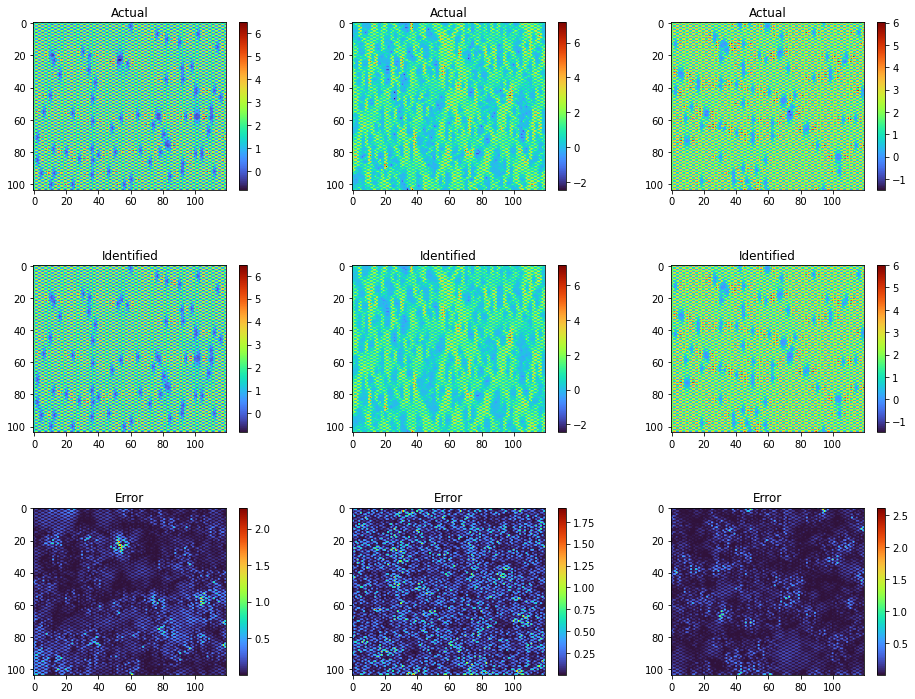

In [10]:
m = torch.mean(pred,0)
# m = pred[0]

""" Plotting """

pred_plt = pred.cpu().detach().numpy()
act_plt = y_test.cpu().numpy()

plt.figure(figsize = (16, 12))
plt.subplots_adjust(hspace=0.45, wspace=0.25)
index = 1
num = 5
for value in range(0+num,3+num):
    
    act = act_plt[value,:,:]
    pre = m[value,:,:]
    
    plt.subplot(3,3, index)
    plt.imshow(act, cmap='turbo', vmin = np.min(act), vmax = np.max(act))
    plt.title('Actual')
    plt.colorbar()

    plt.subplot(3,3, index+3)
    plt.imshow(pre, cmap='turbo', vmin = np.min(act), vmax = np.max(act))
    plt.title('Identified')
    plt.colorbar()
    
    plt.subplot(3,3, index+6)
    plt.imshow(np.abs(pre-act), cmap='turbo',)    
    # plt.imshow(np.abs((pre-act)/(pre+act)), cmap='turbo', vmin = 0, vmax = 1)
    plt.title('Error')
    plt.colorbar()

    # plt.margins(0)
    index = index + 1

print((100*myloss(y_test, m).item())/500)  
print(100*torch.mean((y_test-m)**2).item()/torch.mean((y_test)**2).item())

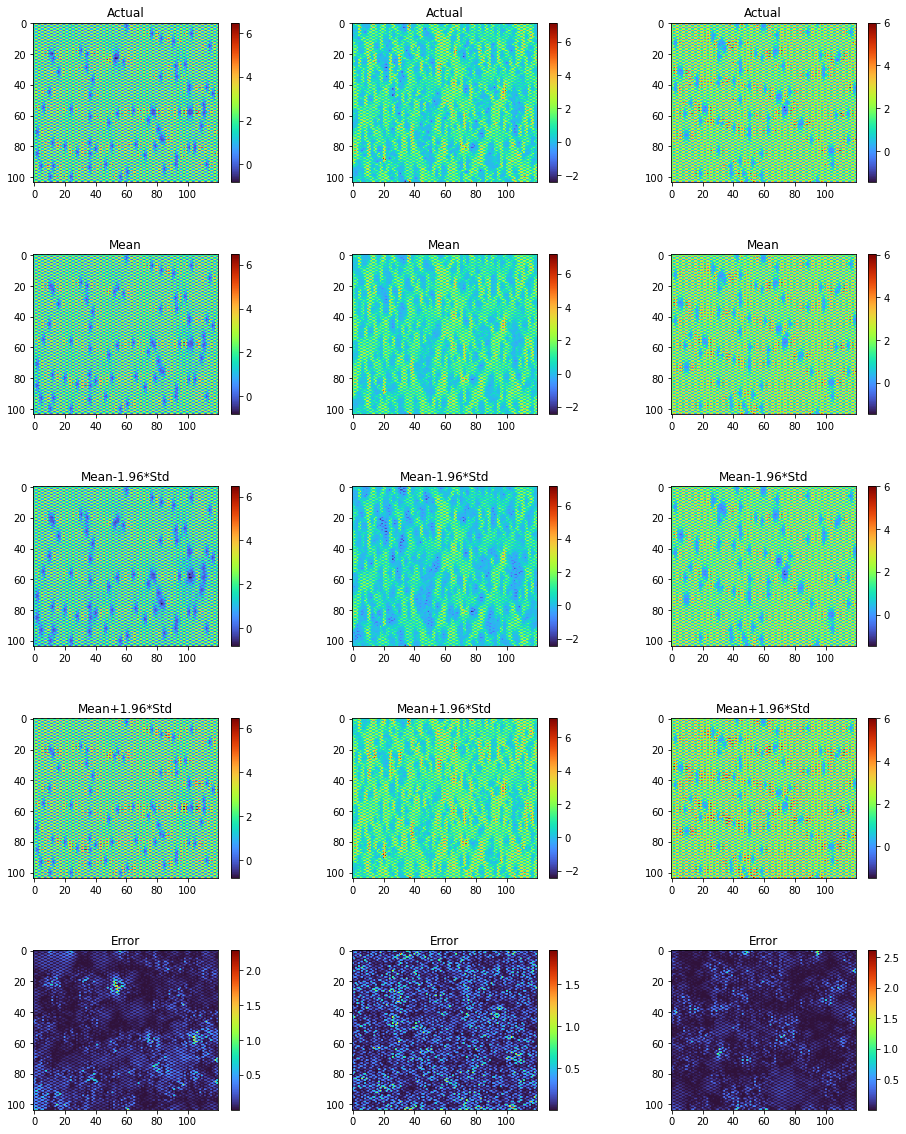

In [11]:
s = torch.std(pred,0)

""" Plotting """

pred_plt = pred.cpu().detach().numpy()
act_plt = y_test.cpu().numpy()

plt.figure(figsize = (16, 20))
plt.subplots_adjust(hspace=0.45, wspace=0.25)
index = 1
num = 5
for value in range(0+num,3+num):
    
    act = act_plt[value,:,:]
    pre = m[value,:,:]
    pres = s[value,:,:]
    
    plt.subplot(5,3, index)
    plt.imshow(act, cmap='turbo', vmin = np.min(act), vmax = np.max(act))
    plt.title('Actual')
    plt.colorbar()

    plt.subplot(5,3, index+3)
    plt.imshow(pre, cmap='turbo', vmin = np.min(act), vmax = np.max(act))
    plt.title('Mean')
    plt.colorbar()
    
    plt.subplot(5,3, index+6)
    plt.imshow(pre-1.96*pres, cmap='turbo', vmin = np.min(act), vmax = np.max(act))
    plt.title('Mean-1.96*Std')
    plt.colorbar()
    
    plt.subplot(5,3, index+9)
    plt.imshow(pre+1.96*pres, cmap='turbo', vmin = np.min(act), vmax = np.max(act))
    plt.title('Mean+1.96*Std')
    plt.colorbar()
    
    plt.subplot(5,3, index+12)
    plt.imshow(np.abs(pre-act), cmap='turbo',)    
    # plt.imshow(np.abs((pre-act)/(pre+act)), cmap='turbo', vmin = 0, vmax = 1)
    plt.title('Error')
    plt.colorbar()

    # plt.margins(0)
    index = index + 1

In [19]:
spi.savemat('./pred/CWT_RPpredmat.mat',mdict={'pred': pred.cpu().numpy(), 'ytest': y_test.cpu().numpy()})

torch.cuda.empty_cache()

In [16]:
# m[samp,:,:].shape, m[samp,0,:].shape, m[samp,:,0].shape

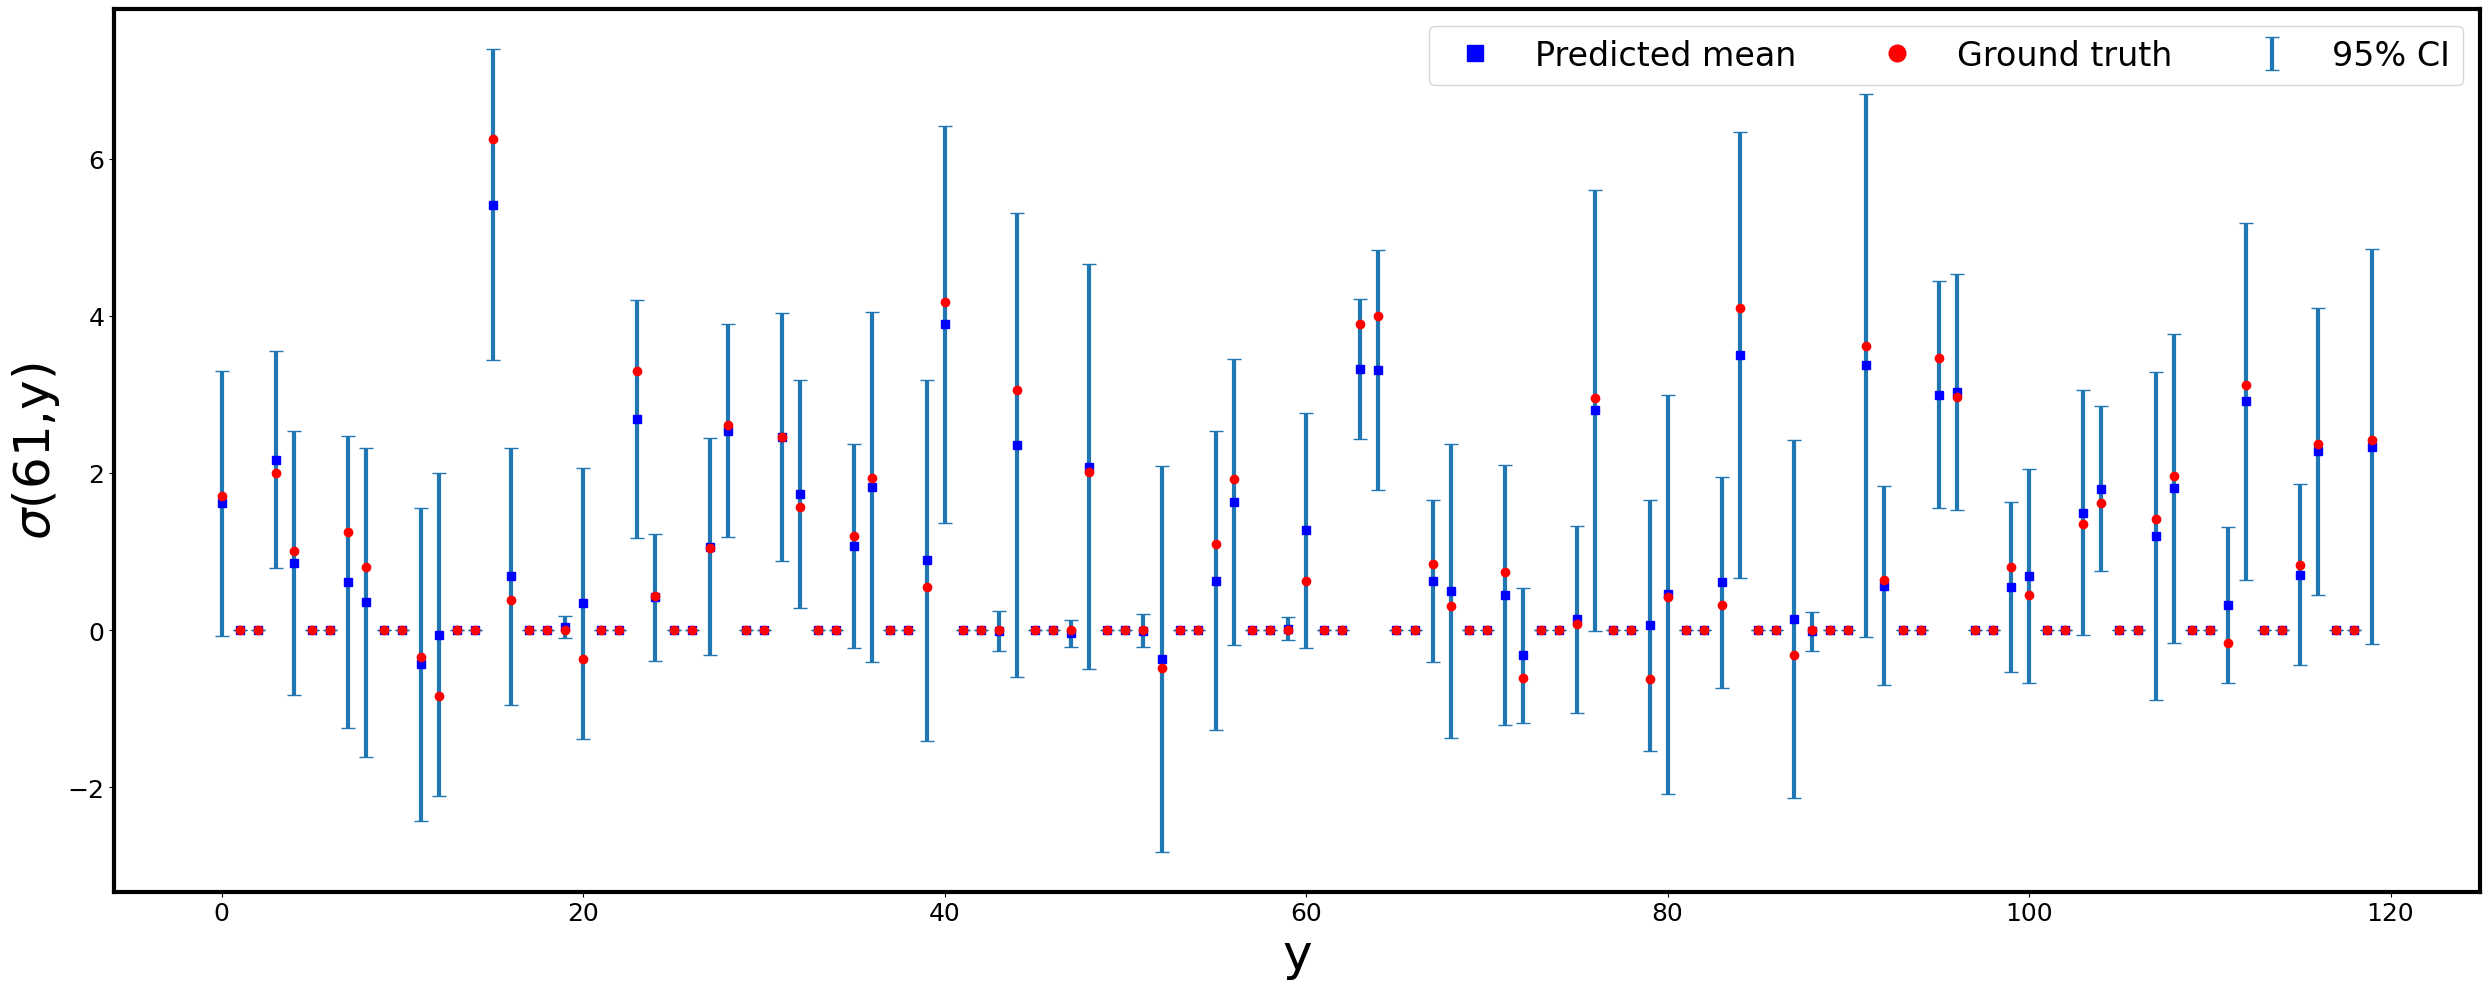

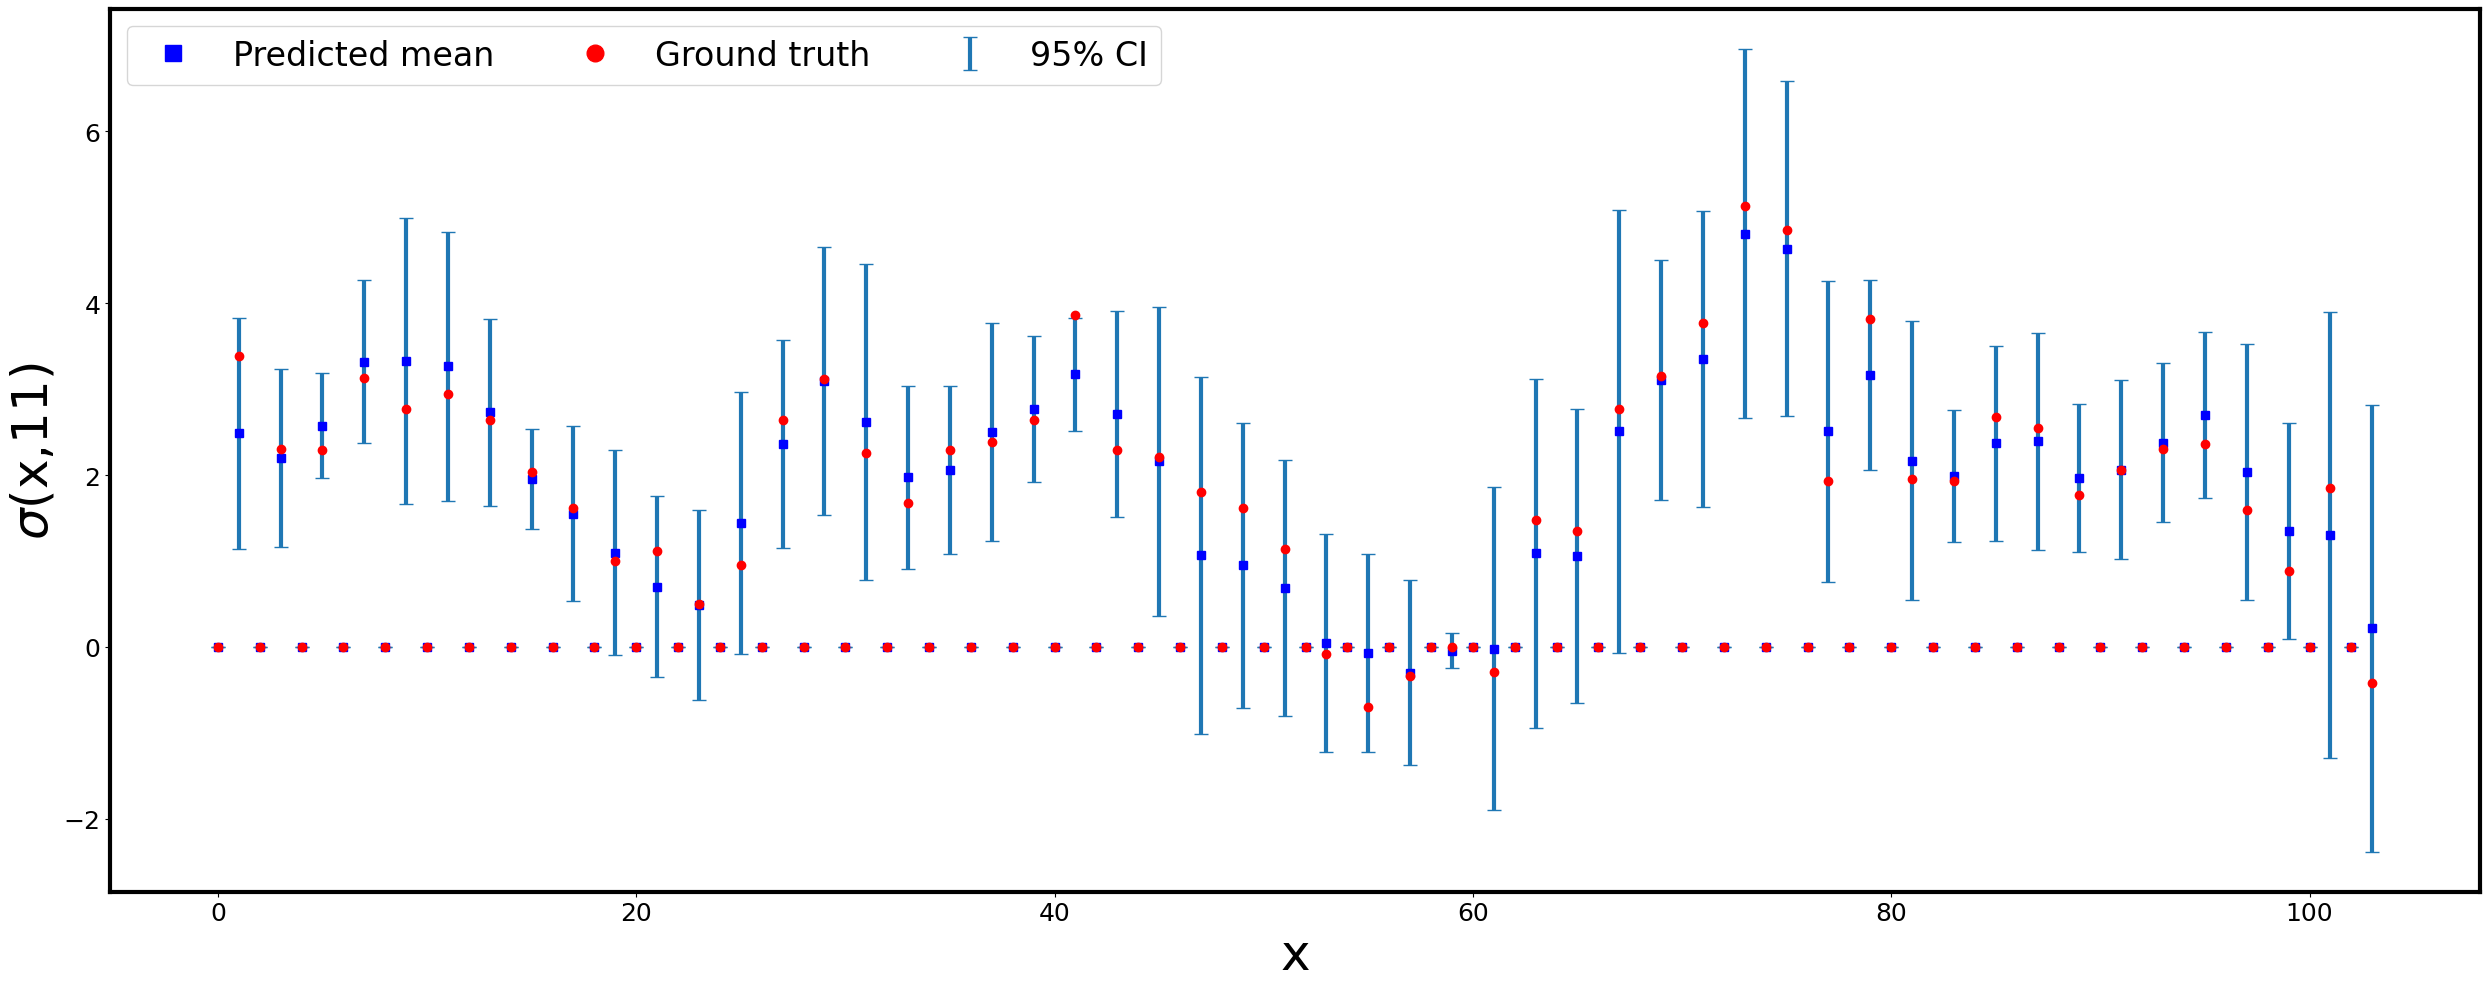

In [20]:
samp = 100
x = 60
y = 10

plt.rcParams['axes.linewidth'] = 3

act = act_plt[samp,x,:]
mpre = m[samp,x,:]
ucl = m[samp,x,:]+1.96*s[samp,x,:]
lcl = m[samp,x,:]-1.96*s[samp,x,:]

plt.figure(figsize=[25,10])
plt.errorbar(np.arange(0,120,1),
             (lcl+ucl)/2,
             yerr = np.abs(ucl-lcl),
             linewidth = 0,
             elinewidth = 3,
             capsize = 5)
plt.plot(mpre,'bs')
plt.plot(act,'ro')

plt.xlabel('y',fontsize=36)
plt.ylabel('$\sigma$(61,y)',fontsize=36)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(('Predicted mean','Ground truth','95% CI'), fontsize=24, ncol=3, markerscale=2)
plt.tight_layout()
plt.savefig('atomic_1.pdf')
plt.show()

act = act_plt[samp,:,y]
mpre = m[samp,:,y]
ucl = m[samp,:,y]+1.96*s[samp,:,y]
lcl = m[samp,:,y]-1.96*s[samp,:,y]

plt.figure(figsize=[25,10])
plt.errorbar(np.arange(0,104,1),
             (lcl+ucl)/2,
             yerr = np.abs(ucl-lcl),
             linewidth = 0,
             elinewidth = 3,
             capsize = 5)
plt.plot(mpre,'bs')
plt.plot(act,'ro')

plt.xlabel('x',fontsize=36)
plt.ylabel('$\sigma$(x,11)',fontsize=36)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(('Predicted mean','Ground truth','95% CI'), fontsize=24, ncol=3, markerscale=2)
plt.tight_layout()
plt.savefig('atomic_2.pdf')
plt.show()

plt.rcdefaults()